In [1]:
# for creating neural network architecture
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *

# for image processing using OpenCV
import cv2

# for dataset management
import os, shutil

# for time management
from tqdm import tqdm

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.list_physical_devices()
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


### Load Dataset


In [3]:
root_dir = '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/Respiratory_Sound_Database'

In [4]:
classify_train = os.path.join(root_dir, 'classify train')

train_directory = os.path.join(classify_train, 'training')
validation_directory = os.path.join(classify_train, 'validation')
test_directory = os.path.join(classify_train, 'testing')

# Analyze Dataset

## Train Dataset

### Get image data

In [5]:
height_lis = []
width_lis = []

total = sum([len(files) for r, d, files in os.walk(classify_train)])

with tqdm(total=total) as pbar:
    for splitname in os.listdir(classify_train):
        split_dir = os.path.join(classify_train, splitname)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                img = cv2.imread(file_path)

                height_lis.append(img.shape[0])
                width_lis.append(img.shape[1])

                pbar.set_description("Progress")
                pbar.update()

Progress: 100%|██████████| 2556/2556 [00:06<00:00, 378.51it/s]


In [6]:
import numpy as np

avg_height = int(np.mean(height_lis))
avg_width = int(np.mean(width_lis))

smallest_height = int(min(height_lis))
smallest_width = int(min(width_lis))

print('Average height & width respectively: {}, {}'.format(avg_height, avg_width))
print('Smallest height & width respectively: {}, {}'.format(smallest_height, smallest_width))

Average height & width respectively: 176, 311
Smallest height & width respectively: 176, 309


### Resize Image

In [7]:
from tqdm import tqdm 

total = sum([len(files) for r, d, files in os.walk(classify_train)])

with tqdm(total=total) as pbar:
    for splitname in os.listdir(classify_train):
        split_dir = os.path.join(classify_train, splitname)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                img = cv2.imread(file_path)
                res = cv2.resize(img, (128, 128))
                cv2.imwrite(file_path, res)
            
                pbar.set_description("Progress")
                pbar.update()

Progress: 100%|██████████| 2556/2556 [00:09<00:00, 256.50it/s]


# Callbacks

In [9]:
learning_rate = 0.001

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))


callback = [tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 10, verbose = 1, mode = "min")]

# Generator

In [10]:
class_no = len(os.listdir(train_directory))
if class_no <= 2:
    class_mode = 'binary'
    output_activation = 'sigmoid'
else:
    class_mode = 'categorical'
    output_activation = 'softmax'
   
target_size = (128, 128)

# Model Architecture

In [11]:
output_activation = 'softmax'
output_neurons = 3

def create_model(output_activation, output_neurons, l):
    model = tf.keras.models.Sequential([
            # 1st layer
            Conv2D(8, (3,3), kernel_regularizer=l2(l), bias_regularizer=l2(l), padding = 'same', input_shape=(128, 128, 3)),
            LeakyReLU(),
            MaxPooling2D(2, 2),
            Dropout(0.30),

            # 2nd layer
            Conv2D(16, (3,3), kernel_regularizer=l2(l), bias_regularizer=l2(l), padding = 'same'),
            LeakyReLU(),
            MaxPooling2D(2,2),
            Dropout(0.30),

            # 3rd layer
            Conv2D(32, (3,3), kernel_regularizer=l2(l), bias_regularizer=l2(l), padding = 'same'),
            LeakyReLU(),
            MaxPooling2D(2,2),
            Dropout(0.30),

            # 4th layer
            Conv2D(64, (3,3), kernel_regularizer=l2(l), bias_regularizer=l2(l), padding = 'same'),
            LeakyReLU(),
            MaxPooling2D(2,2),
            Dropout(0.30),

            # 5th layer
            Conv2D(128, (3,3), kernel_regularizer=l2(l), bias_regularizer=l2(l), padding = 'same'),
            LeakyReLU(),
            MaxPooling2D(2,2),
            Dropout(0.30),



            # flatten
            Flatten(),

            # dense layer
            Dense(128, kernel_regularizer=l2(l), bias_regularizer=l2(l),),
            LeakyReLU(),
            Dropout(0.50),
            Dense(output_neurons, activation = output_activation)
    ])
    
    return model

# Research

Using how many lambdas you want to train with ? 2
Enter 2 lambda value/values consecutively:
Enter lambda value: 0.00001
Enter lambda value: 0.00005
Enter how many batches you want to use: 1
Enter 1 batch no. consecutively:
Enter batch size: 8
Found 2176 images belonging to 3 classes.
Found 126 images belonging to 3 classes.
Found 254 images belonging to 3 classes.

************ for lambda = 1e-05************

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
272/272 [==============================] - 8s 15ms/step - loss: 0.5769 - accuracy: 0.7205 - true_positives: 843.5531 - true_negatives: 1965.5934 - false_positives: 226.3480 - false_negatives: 252.4176 - val_loss: 0.3459 - val_accuracy: 0.7698 - val_true_positives: 97.0000 - val_true_negatives: 223.0000 - val_false_positives: 29.0000 - val_false_negatives: 29.0000

Epoch 00001: loss improved from inf to 0.41976, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/Respiratory_So

272/272 [==============================] - 3s 12ms/step - loss: 0.0450 - accuracy: 0.9867 - true_positives: 1079.6960 - true_negatives: 2175.6667 - false_positives: 16.2747 - false_negatives: 16.2747 - val_loss: 0.0866 - val_accuracy: 0.9841 - val_true_positives: 123.0000 - val_true_negatives: 250.0000 - val_false_positives: 2.0000 - val_false_negatives: 3.0000

Epoch 00014: loss improved from 0.05804 to 0.05577, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/Respiratory_Sound_Database/result/model.h5
Epoch 15/100

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001.
272/272 [==============================] - 3s 12ms/step - loss: 0.0523 - accuracy: 0.9856 - true_positives: 1078.6264 - true_negatives: 2174.5971 - false_positives: 17.3443 - false_negatives: 17.3443 - val_loss: 0.0593 - val_accuracy: 0.9921 - val_true_positives: 125.0000 - val_true_negatives: 251.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000

Epoch 00015: los

272/272 [==============================] - 3s 12ms/step - loss: 0.0651 - accuracy: 0.9801 - true_positives: 1074.5751 - true_negatives: 2170.5458 - false_positives: 21.3956 - false_negatives: 21.3956 - val_loss: 0.0840 - val_accuracy: 0.9762 - val_true_positives: 122.0000 - val_true_negatives: 249.0000 - val_false_positives: 3.0000 - val_false_negatives: 4.0000

Epoch 00029: loss did not improve from 0.04483
Epoch 30/100

Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000003e-05.
272/272 [==============================] - 3s 12ms/step - loss: 0.0543 - accuracy: 0.9824 - true_positives: 1080.4432 - true_negatives: 2176.4139 - false_positives: 15.5275 - false_negatives: 15.5275 - val_loss: 0.0803 - val_accuracy: 0.9683 - val_true_positives: 122.0000 - val_true_negatives: 249.0000 - val_false_positives: 3.0000 - val_false_negatives: 4.0000

Epoch 00030: loss improved from 0.04483 to 0.04333, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrab

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


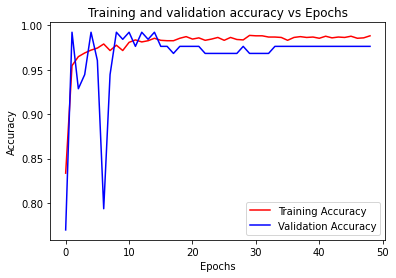

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


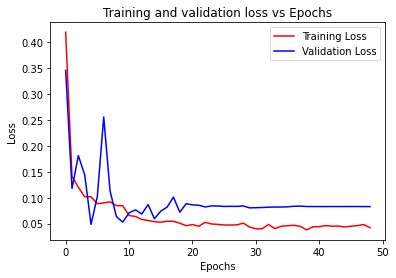

Training accuracy: 0.9733455777168274
Validation accuracy: 0.976190447807312
Blind test accuracy: 0.9724409580230713
Sensitivity: 97.24409448818898
Specificity: 98.62204724409449

************ for lambda = 5e-05************

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
272/272 [==============================] - 5s 13ms/step - loss: 0.5732 - accuracy: 0.7209 - true_positives_1: 844.1905 - true_negatives_1: 1968.1282 - false_positives_1: 223.8132 - false_negatives_1: 251.7802 - val_loss: 0.4114 - val_accuracy: 0.7222 - val_true_positives_1: 91.0000 - val_true_negatives_1: 220.0000 - val_false_positives_1: 32.0000 - val_false_negatives_1: 35.0000

Epoch 00001: loss did not improve from 0.03766
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
272/272 [==============================] - 3s 12ms/step - loss: 0.1950 - accuracy: 0.9429 - true_positives_1: 1036.3810 - true_negatives_1: 2134.0733 - false_positives_1: 57.8681 - fa


Epoch 00016: loss did not improve from 0.03766
Epoch 17/100

Epoch 00017: LearningRateScheduler reducing learning rate to 0.0001.
272/272 [==============================] - 3s 12ms/step - loss: 0.0456 - accuracy: 0.9925 - true_positives_1: 1086.0916 - true_negatives_1: 2183.0842 - false_positives_1: 8.8571 - false_negatives_1: 9.8791 - val_loss: 0.0402 - val_accuracy: 0.9921 - val_true_positives_1: 125.0000 - val_true_negatives_1: 251.0000 - val_false_positives_1: 1.0000 - val_false_negatives_1: 1.0000

Epoch 00017: loss did not improve from 0.03766
Epoch 18/100

Epoch 00018: LearningRateScheduler reducing learning rate to 0.0001.
272/272 [==============================] - 4s 14ms/step - loss: 0.0617 - accuracy: 0.9843 - true_positives_1: 1080.5604 - true_negatives_1: 2176.5311 - false_positives_1: 15.4103 - false_negatives_1: 15.4103 - val_loss: 0.0425 - val_accuracy: 0.9921 - val_true_positives_1: 125.0000 - val_true_negatives_1: 251.0000 - val_false_positives_1: 1.0000 - val_false_


Epoch 00032: loss did not improve from 0.03766
Epoch 33/100

Epoch 00033: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
272/272 [==============================] - 3s 12ms/step - loss: 0.0476 - accuracy: 0.9909 - true_positives_1: 1085.5201 - true_negatives_1: 2181.4908 - false_positives_1: 10.4505 - false_negatives_1: 10.4505 - val_loss: 0.0352 - val_accuracy: 0.9921 - val_true_positives_1: 125.0000 - val_true_negatives_1: 251.0000 - val_false_positives_1: 1.0000 - val_false_negatives_1: 1.0000

Epoch 00033: loss did not improve from 0.03766
Epoch 34/100

Epoch 00034: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
272/272 [==============================] - 3s 12ms/step - loss: 0.0505 - accuracy: 0.9910 - true_positives_1: 1086.6886 - true_negatives_1: 2182.6593 - false_positives_1: 9.2821 - false_negatives_1: 9.2821 - val_loss: 0.0353 - val_accuracy: 0.9921 - val_true_positives_1: 125.0000 - val_true_negatives_1: 251.0000 - val_false_

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Epoch 00035: loss did not improve from 0.03766
Epoch 00035: early stopping


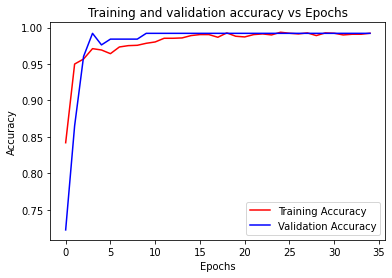

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


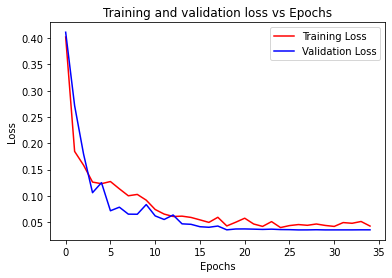

Training accuracy: 0.9972426295280457
Validation accuracy: 0.9920634627342224
Blind test accuracy: 0.9960629940032959
Sensitivity: 99.60629921259843
Specificity: 99.80314960629921


In [12]:
epoch = 100

lambd_list = []
lambd_no = int(input('Using how many lambdas you want to train with ? '))
print('Enter {} lambda value/values consecutively:'.format(lambd_no))
for i in range(lambd_no): 
    lambd = float(input('Enter lambda value: '))
    lambd_list.append(lambd)

batch_list = []
batch_no = int(input("Enter how many batches you want to use: "))
print('Enter {} batch no. consecutively:'.format(batch_no))
for j in range(batch_no):
    b_size = int(input('Enter batch size: '))
    batch_list.append(b_size)

for batch_size in batch_list:
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_generator = train_datagen.flow_from_directory(train_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    validation_generator = val_datagen.flow_from_directory(validation_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(test_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)
    for l in lambd_list:
        model = create_model(output_activation, output_neurons, l)
        
        # COMPILE
        loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        model.compile(loss = loss,
                    optimizer = optimizer,
                    metrics=['accuracy',
                    tf.keras.metrics.TruePositives(), 
                    tf.keras.metrics.TrueNegatives(), 
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()])

        print ('\n************ for lambda = {}************\n'.format(l))


        # FIT
        history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle = True)


        # PLOT
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        import matplotlib.pyplot as plt
        
        # Accuracy vs Epochs
        plt.plot(epochs, acc, 'r', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy vs Epochs')
        plt.legend()
        plt.show()
        
        # Loss vs Epochs
        plt.plot(epochs, loss, 'r', label="Training Loss")
        plt.plot(epochs, val_loss, 'b', label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss vs Epochs')
        plt.legend()
        plt.show()


        # ACCURACIES
        print("Training accuracy: {}".format(model.evaluate(train_generator, verbose=0)[1]))
        print("Validation accuracy: {}".format(model.evaluate(validation_generator, verbose=0)[1]))
        print("Blind test accuracy: {}".format(model.evaluate(test_generator, verbose=0)[1]))
        tp = int(model.evaluate(test_generator, verbose=0)[2])
        tn = int(model.evaluate(test_generator, verbose=0)[3])
        fp = int(model.evaluate(test_generator, verbose=0)[4])
        fn = int(model.evaluate(test_generator, verbose=0)[5])
        sensitivity = (tp/(tp+fn))*100
        specificity = (tn/(tn+fp))*100
        print("Sensitivity: {}".format(sensitivity))
        print("Specificity: {}".format(specificity))
